# Preliminaries 
Initial packages and testing functions 

In [7]:
import sys
import numpy as np
import gym
from matplotlib import pyplot as plt
from dqn import DQN
from drqn import DRQN, Memory
from reinforce import REINFORCE, PiApproximationWithNN, Baseline
from reinforce_Buffer import REINFORCE as RF_Buffer, PiApproximationWithNN as Pi_Buffer, ReplayMemory
from reinforce_Estimate import REINFORCE as RF_Est, PiApproximationWithNN as Pi_Est
import warnings
warnings.filterwarnings('ignore')

def test_DQN(env, run):
    gamma = 1.0
    return DQN(env, gamma, 1000, run)


def test_DRQN(env, run):
    gamma = 1.0
    return DRQN(env, gamma, 1000, run)

def test_reinforce(env,runs):
    gamma = 1.
    alpha = 3e-4

    if 'tensorflow' in sys.modules:
        import tensorflow as tf
        tf.reset_default_graph()

    pi = PiApproximationWithNN(
        env.observation_space.shape[0],
        env.action_space.n,
        alpha)

    B = Baseline(0.)

    return REINFORCE(env, gamma, 1000, runs, pi, B)


def test_reinforce_Buffer(env, mem_size, runs):
    gamma = 1.
    alpha = 3e-4

    if 'tensorflow' in sys.modules:
        import tensorflow as tf
        tf.reset_default_graph()

    pi = Pi_Buffer(
        env.observation_space.shape[0],
        env.action_space.n,
        alpha,
        mem_size)

    B = Baseline(0.)

    return RF_Buffer(env, gamma, 1000, runs, pi, B, mem_size)

def test_reinforce_Estimate(env, mem_size, runs):
    gamma = 1.
    alpha = 3e-4

    if 'tensorflow' in sys.modules:
        import tensorflow as tf
        tf.reset_default_graph()

    pi = Pi_Est(
        env.observation_space.shape[0],
        env.action_space.n,
        alpha,
        mem_size)

    B = Baseline(0.)

    return RF_Est(env, gamma, 1000, runs, pi, B, mem_size)




# Reinforce Approaches

In this section we compare 3 policy classes:
1. Memoryless
2. A memory sequence buffer (2 and 5 observations) 
3. An memory-based estimate of the state 

In [ ]:
num_iter = 10
env = gym.make("CartPole-v0")

without_buffer = []
print('***************************************')
for q in range(num_iter):
    print("----------------> Without Buffer: {}".format(q))
    training_progress = test_reinforce(env,q)
    without_buffer.append(training_progress[0])
    pi = training_progress[1]
print('***************************************')
without_buffer = np.mean(without_buffer, axis=0)
    
# Test REINFORCE_buffer size 2 and 5
with_buffer2 = []
print('***************************************')
for q in range(num_iter):
    print("----------------> With Buffer = 2: {}".format(q))
    training_progress = test_reinforce_Buffer(env, 2, q)
    with_buffer2.append(training_progress[0])
    pi_buff = training_progress[1]
print('***************************************')
with_buffer2 = np.mean(with_buffer2, axis=0)

with_buffer5 = []
print('***************************************')
for q in range(num_iter):
    print("----------------> With Buffer = 5: {}".format(q))
    training_progress = test_reinforce_Buffer(env, 5, q)
    with_buffer5.append(training_progress[0])
    pi_buff = training_progress[1]
print('***************************************')
with_buffer5 = np.mean(with_buffer5, axis=0)

# Test REINFORCE_estimate
with_est = []
print('***************************************')
for q in range(num_iter):
    print("----------------> With Estiamte: {}".format(q))
    training_progress = test_reinforce_Estimate(env, 2, q)
    with_est.append(training_progress[0])
    pi_est = training_progress[1]
print('***************************************')
with_est = np.mean(with_est, axis=0)
    

***************************************
----------------> Without Buffer: 0
----------------> Without Buffer: 1
----------------> Without Buffer: 2
----------------> Without Buffer: 3
----------------> Without Buffer: 4
----------------> Without Buffer: 5
----------------> Without Buffer: 6
----------------> Without Buffer: 7
----------------> Without Buffer: 8
----------------> Without Buffer: 9
***************************************
***************************************
----------------> With Buffer = 2: 0
----------------> With Buffer = 2: 1
----------------> With Buffer = 2: 2
----------------> With Buffer = 2: 3


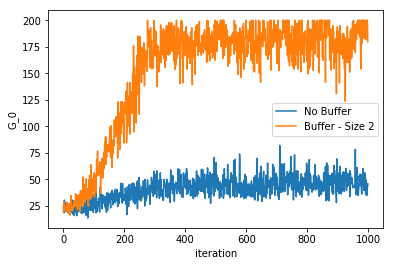

In [6]:
# Plot the experiment result
fig,ax = plt.subplots()
ax.plot(np.arange(len(without_buffer)), without_buffer, label='No Buffer')
ax.plot(np.arange(len(with_buffer2)), with_buffer2, label='Buffer - Size 2')
ax.plot(np.arange(len(with_buffer5)), with_buffer5, label='Buffer - Size 5')
ax.plot(np.arange(len(with_est)), with_est, label='Buffer - Size 5')

ax.set_xlabel('iteration')
ax.set_ylabel('G_0')
ax.legend()

plt.show()


### Result discussion
The policy that uses the state estimate from memory clearly outperforms both the memoryless and the memory sequence policies. The comparison is not technically an even one since the state estimate method uses domain knowledge that the other two policies do not have.
The really poor performance of the memory sequences is likely a result of the _curse of history_ as the number of samples required explodes with each additional observation in the sequence.

# Deep Q-Learning with Memory

In [ ]:
# # Test DQN
dqn_list = []
dqn_policies = []
for q in range(num_iter):
    dqn_rew, dqn_pi = test_DQN(env, q)
    dqn_list.append(dqn_rew)
    dqn_policies.append(dqn_pi)
dqn_result = np.mean(dqn_list,axis=0)
smoothed_dqn_result = running_mean(dqn_result, 10)
#
# Test DRQN
drqn_list = []
drqn_policies = []
for q in range(num_iter):
    drqn_rew, drqn_pi = test_DRQN(env, q)
    drqn_list.append(drqn_rew)
    drqn_policies.append(drqn_pi)
drqn_result = np.mean(drqn_list, axis=0)
smoothed_drqn_result = running_mean(drqn_result, 10)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(smoothed_dqn_result)), smoothed_dqn_result, label='DQN_smoothed')
ax.plot(np.arange(len(dqn_result)), dqn_result, label='DQN', color='red', alpha=0.3)
ax.plot(np.arange(len(smoothed_drqn_result)), smoothed_drqn_result, label='DRQN_smoothed')
ax.plot(np.arange(len(drqn_result)), drqn_result, label='DRQN', color='grey', alpha=0.3)

ax.set_xlabel('iteration')
ax.set_ylabel('G_0')
ax.legend()

plt.show()


### Result discussion

Clearly adding an LSTM memory layer for DRQN gives a policy that acheives greater performance for Cartpole than the memoryless case in DQN.
